--- Loading MA-UNet Model ---



Model Loaded Successfully.

--- Processing: urban1.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


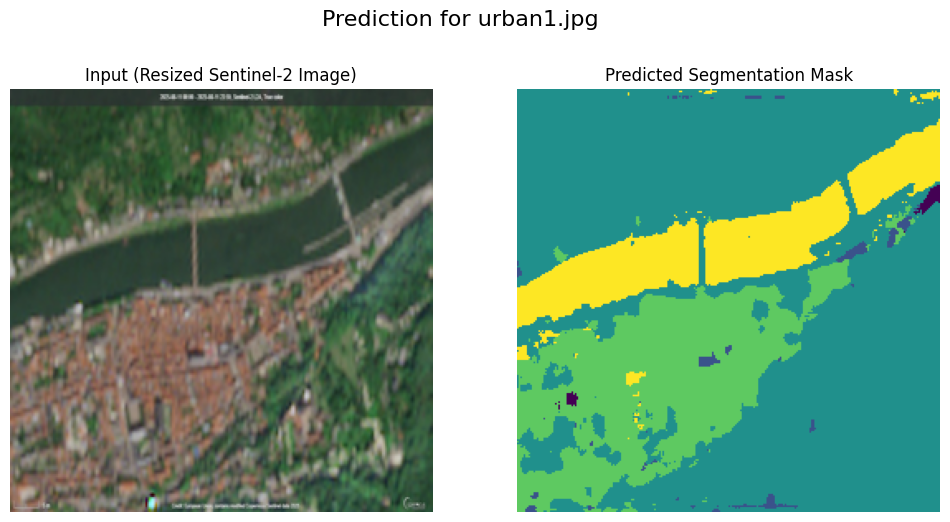


--- Processing: urban2.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


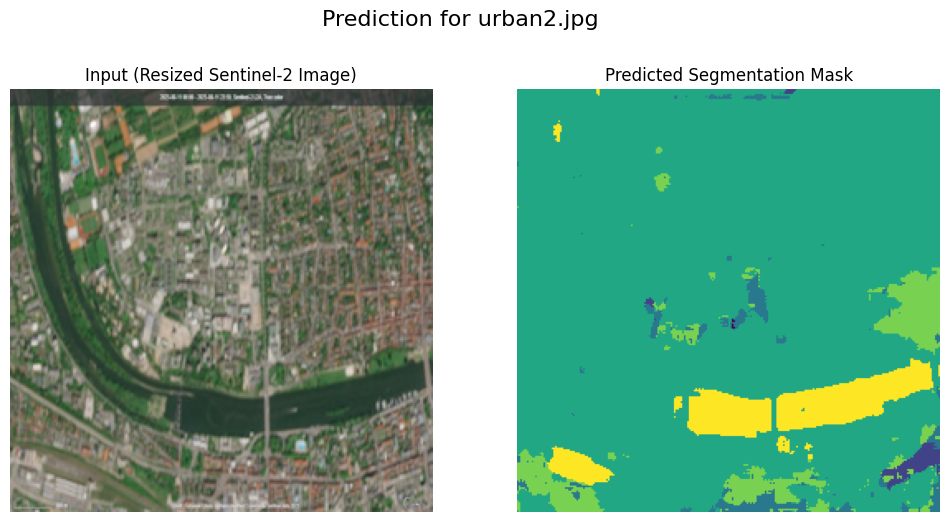


--- Processing: agrifields1.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


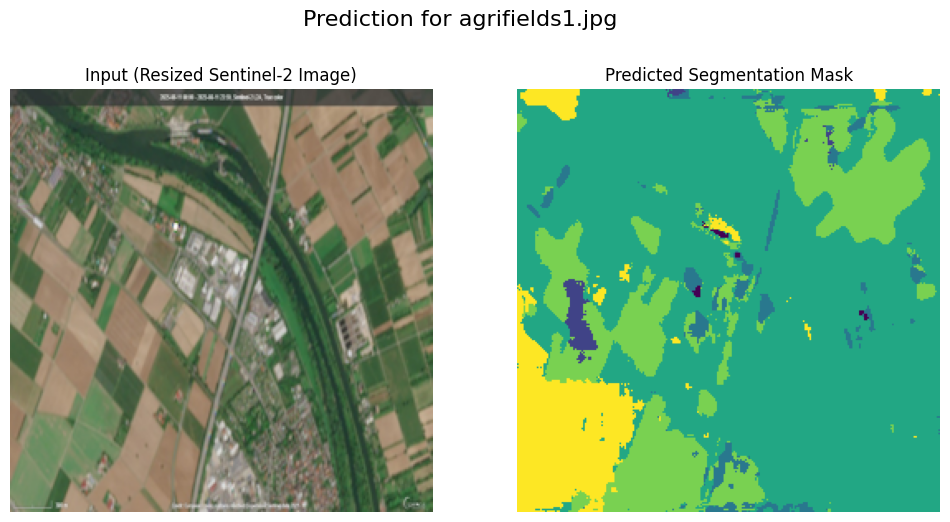


--- All images processed. ---


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K

# --- Define the custom layer needed to load your model ---
# This must be included so Keras knows what a 'simam_module' is
class simam_module(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(simam_module, self).__init__(**kwargs)
        self.activaton = tf.keras.activations.sigmoid
        self.e_lambda = 1e-4
    def call(self, x):
        _, h, w, c = x.shape
        n = w * h - 1
        d = (x - K.mean(x, axis=[1,2], keepdims=True)) ** 2
        v = K.sum(d, axis=[1,2], keepdims=True) / n
        e = d / (4 * (v + self.e_lambda)) + 0.5
        return x * self.activaton(e)

# --- 1. Load your trained model ---
print("--- Loading MA-UNet Model ---")
# The model is in the same folder as this notebook, so the path is simple
model_path = 'ma_unet_model.h5' 
model = tf.keras.models.load_model(model_path, custom_objects={'simam_module': simam_module})
print("Model Loaded Successfully.")

# --- 2. List the images you want to test ---
# This list should match the filenames you placed in this folder
image_filenames = ['urban1.jpg', 'urban2.jpg', 'agrifields1.jpg']
IMG_SIZE = 256

# --- 3. Loop through each image to process and visualize ---
for image_name in image_filenames:
    print(f"\n--- Processing: {image_name} ---")
    
    try:
        # Load and Preprocess the Image
        image = Image.open(image_name).convert('RGB')
        image_resized = image.resize((IMG_SIZE, IMG_SIZE))
        image_array = np.array(image_resized) / 255.0
        image_batch = np.expand_dims(image_array, axis=0)

        # Make a Prediction
        prediction = model.predict(image_batch)
        predicted_mask = tf.argmax(prediction, axis=-1)[0]

        # Visualize the Result
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f"Prediction for {image_name}", fontsize=16)

        axes[0].imshow(image_resized)
        axes[0].set_title("Input (Resized Sentinel-2 Image)")
        axes[0].axis('off')

        axes[1].imshow(predicted_mask)
        axes[1].set_title("Predicted Segmentation Mask")
        axes[1].axis('off')
        
        plt.show()

    except FileNotFoundError:
        print(f"ERROR: Could not find '{image_name}'. Please make sure the file is in the 'notebooks' folder.")

print("\n--- All images processed. ---")
